In [451]:
#### Udacity Self Driving Car Term1 Project No.5 
#### Vehicle Detection and Tracking

In [452]:
#### The Goal of this Project
###################################################################################################################
# In this project, your goal is to write a software pipeline to identify vehicles in a video from a front-facing 
# camera on a car. The test images and project video are available in the project repository. There is an writeup 
# template in the repostitory provided as a starting point for your writeup of the project.
###################################################################################################################

In [453]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

In [454]:
### 1. Load the Data Set

In [455]:
### 1.1 Form Car/Non-Car Images Names

# There are four GTI folders for car images
# vehicles/GTI_Far
# vehicles/GTI_Left
# vehicles/GTI_MiddleClose
# vehicles/GTI_Right

# And one folder for GTI non-car images
# non-vehicles/GTI

cars = []
non_cars = []

# car image names arrays
images1 = glob.glob('vehicles/GTI_Far/*.png')
images2 = glob.glob('vehicles/GTI_Left/*.png')
images3 = glob.glob('vehicles/GTI_MiddleClose/*.png')
images4 = glob.glob('vehicles/GTI_Right/*.png')
images5 = glob.glob('vehicles/KITTI_extracted/*.png')
# non car image names array
images6 = glob.glob('non-vehicles/GTI/*.png')
images7 = glob.glob('non-vehicles/Extras/*.png')

cars = images1 + images2 + images3 + images4 + images5
non_cars = images6 + images7

print("cars sample size: ", len(cars))
print("non cars sample size: ", len(non_cars))

cars sample size:  8792
non cars sample size:  8968


In [456]:
### 1.2 Test Show One Car and Non-Car Image

In [457]:
# Define a Utility Func to Show Two Images
def show_two_imgs(img1, img2, title1, title2, size=(10,5)):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=size)
    ax1.imshow(img1)
    ax1.set_title(title1)
    
    ax2.imshow(img2)
    ax2.set_title(title2)  
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

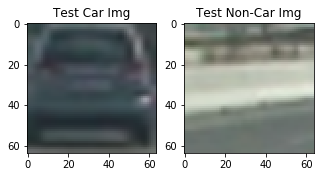

In [458]:
car_test = mpimg.imread(cars[10])
non_car_test = mpimg.imread(non_cars[10])

ttl1 = "Test Car Img"
ttl2 = "Test Non-Car Img"

show_two_imgs(car_test,non_car_test,ttl1,ttl2,(4,2))

In [459]:
### 2. Classification Pipline Construction

### Two different ways to build the pipline will be considered
# Color Classification Pipline & Histogram of Gradients(HOG) Classification Pipline

In [460]:
### 2.1 Color Classification Pipline Construction

In [461]:
# The idea of using color to classify cars from non-cars is to extract out the R, G, B from an image 
# and concatenate them into an feature array.
# The following function will demonstrate the process of extract the R, G, B feature array

In [462]:
# Define a function to compute color histogram features  
def color_hist_demo(image, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0]*255., bins=32, range=(0, 256))
    ghist = np.histogram(image[:,:,1]*255., bins=32, range=(0, 256))
    bhist = np.histogram(image[:,:,2]*255., bins=32, range=(0, 256))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [463]:
# Define a Utility Func to Show Car/Non-Car Image along with their R, G, B Histogram Chart
def show_img_with_rgb_hist(img,rh,gh,bh):
    fig = plt.figure(figsize=(15,3))
    plt.subplot(141)
    plt.imshow(img)
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    plt.show()

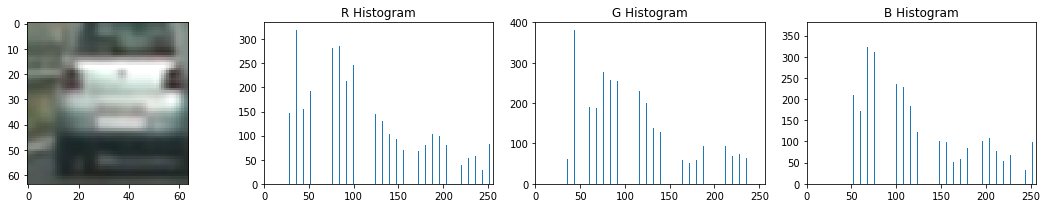

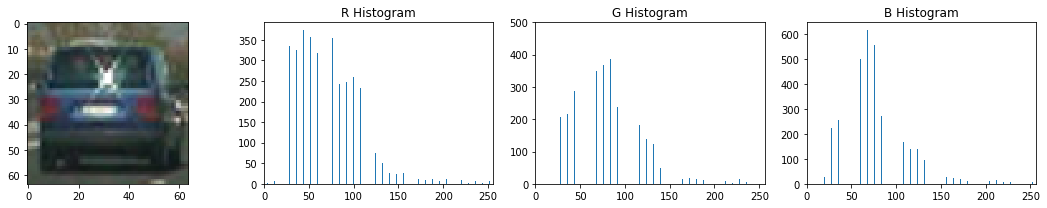

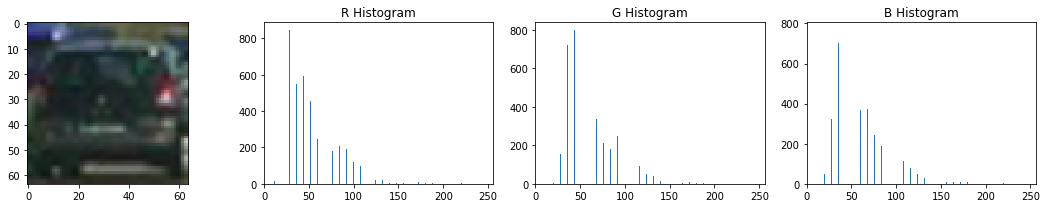

In [464]:
# Show Color Hist with Car Images
# Car 1
car_rgb_test_1 = mpimg.imread(cars[100])
rh, gh, bh, bincen, feature_vec = color_hist_demo(car_rgb_test_1, nbins=32, bins_range=(0, 256))

if rh is not None:
    show_img_with_rgb_hist(car_rgb_test_1,rh,gh,bh)
    
# Car 2
car_rgb_test_2 = mpimg.imread(cars[200])
rh, gh, bh, bincen, feature_vec = color_hist_demo(car_rgb_test_2, nbins=32, bins_range=(0, 256))

if rh is not None:
    show_img_with_rgb_hist(car_rgb_test_2,rh,gh,bh)
    
# Car 3
car_rgb_test_3 = mpimg.imread(cars[300])
rh, gh, bh, bincen, feature_vec = color_hist_demo(car_rgb_test_3, nbins=32, bins_range=(0, 256))

if rh is not None:
    show_img_with_rgb_hist(car_rgb_test_3,rh,gh,bh)

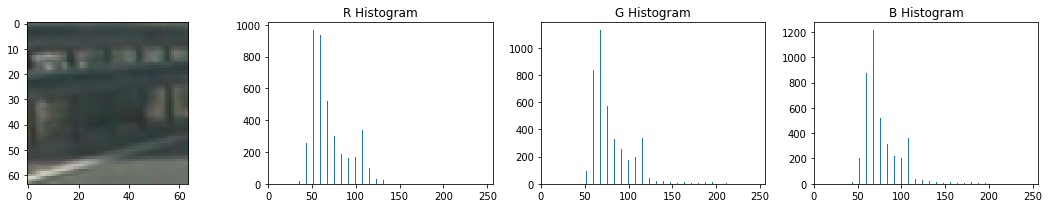

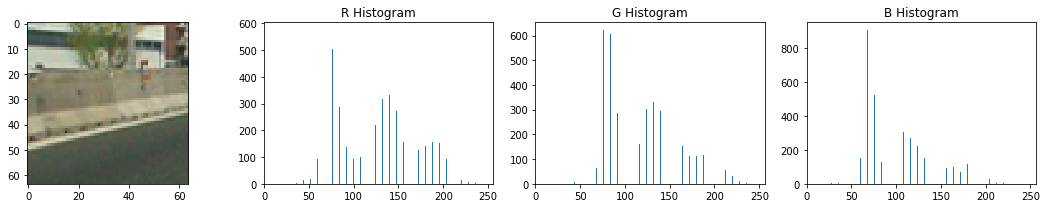

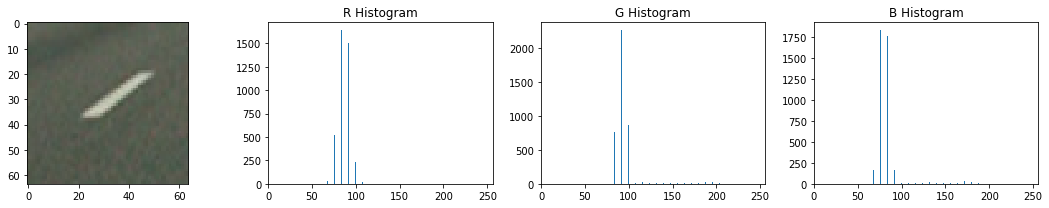

In [465]:
# Show Color Hist with Non-car Images
# Car 1
non_car_rgb_test_1 = mpimg.imread(non_cars[100])
rh, gh, bh, bincen, feature_vec = color_hist_demo(non_car_rgb_test_1, nbins=32, bins_range=(0, 256))

if rh is not None:
    show_img_with_rgb_hist(non_car_rgb_test_1,rh,gh,bh)
    
# Car 2
non_car_rgb_test_2 = mpimg.imread(non_cars[200])
rh, gh, bh, bincen, feature_vec = color_hist_demo(non_car_rgb_test_2, nbins=32, bins_range=(0, 256))

if rh is not None:
    show_img_with_rgb_hist(non_car_rgb_test_2,rh,gh,bh)
    
# Car 3
non_car_rgb_test_3 = mpimg.imread(non_cars[300])
rh, gh, bh, bincen, feature_vec = color_hist_demo(non_car_rgb_test_3, nbins=32, bins_range=(0, 256))

if rh is not None:
    show_img_with_rgb_hist(non_car_rgb_test_3,rh,gh,bh)

In [466]:
# To create the color classification pipeline, following two utility functions will be needed. 
# (refering Udacity project 5 lessons.)

In [467]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [468]:
# Define a function to compute color histogram features 
# (No need to show all histogram again so remove some output comparing to the function color_hist_demo)
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [469]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

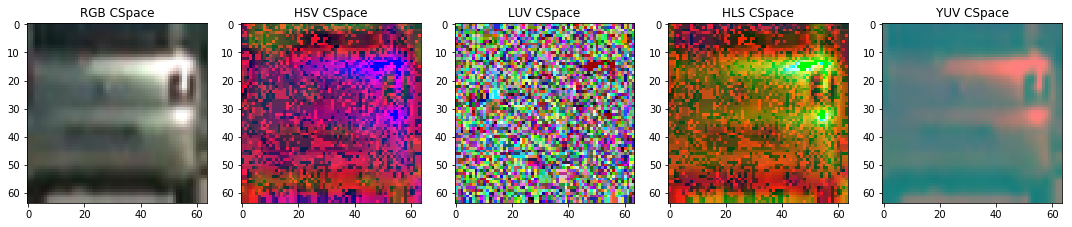

In [470]:
# In the above feature extraction function, the color spacing is involved.
# Different color spacing of an image will be shown in the following block
car_rgb = mpimg.imread(cars[400])
car_hsv = cv2.cvtColor(car_rgb, cv2.COLOR_RGB2HSV)
car_luv = cv2.cvtColor(car_rgb, cv2.COLOR_RGB2LUV)
car_hls = cv2.cvtColor(car_rgb, cv2.COLOR_RGB2HLS)
car_yuv = cv2.cvtColor(car_rgb, cv2.COLOR_RGB2YUV)

fig = plt.figure(figsize=(15,3))
plt.subplot(151)
plt.title('RGB CSpace')
plt.imshow(car_rgb)
plt.subplot(152)
plt.title('HSV CSpace')
plt.imshow(car_hsv)
plt.subplot(153)
plt.title('LUV CSpace')
plt.imshow(car_luv)
plt.subplot(154)
plt.title('HLS CSpace')
plt.imshow(car_hls)
plt.subplot(155)
plt.title('YUV CSpace')
plt.imshow(car_yuv)
fig.tight_layout()
plt.show()

In [471]:
# Different color spacing returns different training features. By default, the color spacing is set to be RGB.

In [472]:
### Training

In [473]:
# First step of training is to get the features and labels ready.
# From the previous section, we have created the functions to extract features

# performs under different binning scenarios
spatial = 32
histbin = 32

# select first 1000 images in both cars and non cars names array
color_clas_cars = cars[0:1000]
color_clas_non_cars = non_cars[0:1000]

car_features = extract_features(color_clas_cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(color_clas_non_cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

In [474]:
# Before we use X as the training feature, we'd better to rescale the features.
# So that neither bin features nor color features will dominate the other ones.

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [475]:
# Now, we need to create labels

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [476]:
# Also, we need to split our data into two parts, training and validation sets, of course, randomly.

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [477]:
print('Prepare to train the linear SVC(support vector classifier) for the color classification')
print('Using spatial binning of:',spatial, 'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Prepare to train the linear SVC(support vector classifier) for the color classification
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
2.9 Seconds to train SVC...
Test Accuracy of SVC =  0.9475
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  0.  0.  0.  1.]
0.00161 Seconds to predict 10 labels with SVC


In [478]:
### 2.2 Histogram of Gradients(HOG) Classification Construction

In [479]:
# The idea of using HOG to classify cars from non-cars is to extract out the HOG features to classify images
# To use the hog function from the sciki image library, we have to define cells and blocks
# Cells are defined with m*n pixels
# Blocks are defined with m*n cells
# Also we can customized gradient changing orientations, usually the range is 9-12

In [480]:
# In the following section, I will demonstrate the function that extract hog features

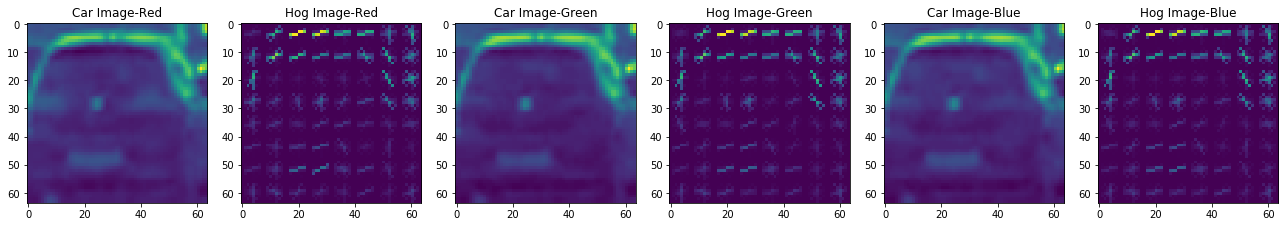

In [481]:
car_hog_1 = mpimg.imread(cars[500])[:,:,0]*255 #rescale from 0-1 to 0-255
car_hog_2 = mpimg.imread(cars[500])[:,:,1]*255 #rescale from 0-1 to 0-255
car_hog_3 = mpimg.imread(cars[500])[:,:,2]*255 #rescale from 0-1 to 0-255

orient_hog = 9
pix_per_cell = 8
cell_per_block = 2

features, hog_image_1 = hog(car_hog_1, orientations=orient_hog, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=True)

features, hog_image_2 = hog(car_hog_2, orientations=orient_hog, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=True)

features, hog_image_3 = hog(car_hog_3, orientations=orient_hog, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=True)

fig = plt.figure(figsize=(18,3))
plt.subplot(161)
plt.title('Car Image-Red')
plt.imshow(car_hog_1)
plt.subplot(162)
plt.title('Hog Image-Red')
plt.imshow(hog_image_1)
plt.subplot(163)
plt.title('Car Image-Green')
plt.imshow(car_hog_2)
plt.subplot(164)
plt.title('Hog Image-Green')
plt.imshow(hog_image_2)
plt.subplot(165)
plt.title('Car Image-Blue')
plt.imshow(car_hog_3)
plt.subplot(166)
plt.title('Hog Image-Blue')
plt.imshow(hog_image_3)
fig.tight_layout()
plt.show()

In [482]:
# Now, we will build the classifier

In [483]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [484]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [485]:
# Prepare the basic parameters for the pipline

sample_size = 1000
cars_hog = cars[0:]
non_cars_hog = non_cars[0:]

colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

In [486]:
# Record the time for extracting features
t=time.time()
car_features = extract_features(cars_hog, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(non_cars_hog, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

39.69 Seconds to extract HOG features...


In [487]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [488]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764


In [489]:
# Use a linear SVC 
svc2 = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc2.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc2.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc2.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

15.7 Seconds to train SVC...
Test Accuracy of SVC =  0.9122
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  0.  1.  1.  0.]
0.0024 Seconds to predict 10 labels with SVC


In [490]:
### 3. Sliding Windows

In [491]:
# After we created the classification pipline in two ways. Because we don't know the exact location and 
# size of the car image as apart of the video frame, we have to find a way to search a frame of 
# a picture of the video.

In [492]:
# Define the function to draw rectangulars
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [493]:
# Define a function to demonstrate the sliding window process
# that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1]-x_start_stop[0]
    yspan = y_start_stop[1]-y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

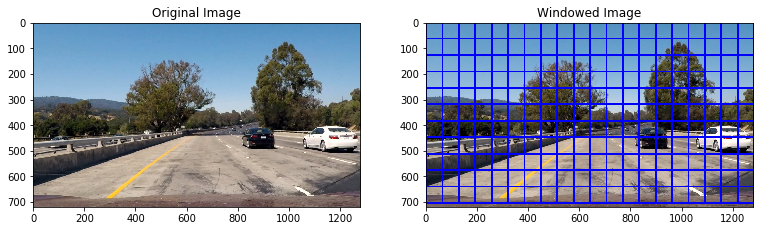

In [494]:
windows_test_img = mpimg.imread('test_images/test1.jpg')

windows = slide_window(windows_test_img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(windows_test_img, windows, color=(0, 0, 255), thick=6)                    

ttl1 = "Original Image"
ttl2 = "Windowed Image"

show_two_imgs(windows_test_img,window_img,ttl1,ttl2,(10,4))

In [495]:
### 4. Combining Color Features, HOG Features and Sliding Windows 

In [496]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [497]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_combine(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [498]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [499]:
# Now I will setup all the parameters and find cars in an image in the followin block
cars_combine = cars[0:]
notcars_combine = non_cars[0:]

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [380, 650] # Min and max in y to search in slide_window()

In [500]:
car_features = extract_features_combine(cars_combine, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features_combine(notcars_combine, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc3 = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc3.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc3.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
18.5 Seconds to train SVC...
Test Accuracy of SVC =  0.9893


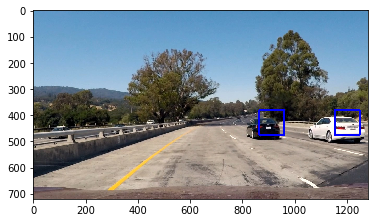

In [501]:
combine_test_img = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(combine_test_img)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
combine_test_img = combine_test_img.astype(np.float32)/255.

windows = slide_window(combine_test_img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(combine_test_img, windows, svc3, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()

In [502]:
### 5. Hog Sub-sampling Window Search - More Effient Windows Search 

In [503]:
# The code below defines a single function find_cars that's able to both extract features and make predictions.
# The find_cars only has to extract hog features once and then can be sub-sampled to get all of its overlaying 
# windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells
# then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result
# in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values
# to generate multiple-scaled search windows.

In [504]:
# Define a Utilty func for Color Convertion
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [532]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

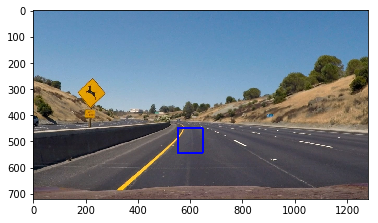

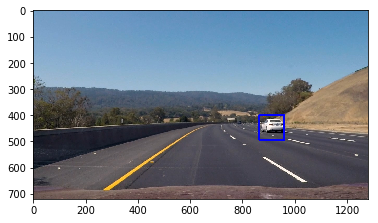

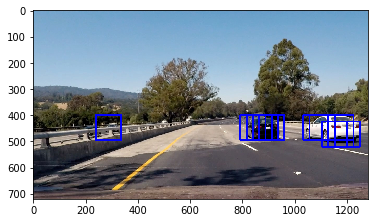

In [533]:
ystart = 400
ystop = 656
scale = 1.5

combine_test_img2 = mpimg.imread('test_images/test2.jpg')
out_img2 = find_cars(combine_test_img2, ystart, ystop, scale, svc3, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img2)
plt.show()

combine_test_img3 = mpimg.imread('test_images/test3.jpg')
out_img3 = find_cars(combine_test_img3, ystart, ystop, scale, svc3, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img3)
plt.show()

combine_test_img4 = mpimg.imread('test_images/test4.jpg')
out_img4 = find_cars(combine_test_img4, ystart, ystop, scale, svc3, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img4)
plt.show()

In [534]:
### 6. Multiple Detections & False Positives

In [535]:
# It is worth noting that result of finding cars in the above three test images, sometimes it has false 
# result, while some times it has duplicated or redundent result, in this section, I will implement few functions 
# to handle this issues.

# The idea to handle this is to use heat map with thresh hold while we searching cars.

In [536]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [537]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [538]:
# Create a new function using Hog Sub-sampling but returns boxs list

In [542]:
def find_cars_windows(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    windows = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
                        
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)) 
                windows.append(box)
                
    return windows

In [543]:
# Read in image similar to one shown above 
heat_test_image4 = mpimg.imread('test_images/test4.jpg')
heat = np.zeros_like(heat_test_image4[:,:,0]).astype(np.float)

windows4 = find_cars_windows(heat_test_image4, ystart, ystop, scale, svc3, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print("found windows amount: ", len(windows))
print("first found window: ", windows[0])

found windows amount:  100
((0, 380), (96, 476))


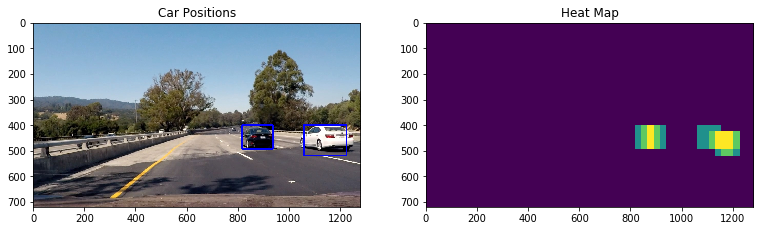

In [547]:
# Add heat to each box in box list
heat = add_heat(heat,windows4)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(heat_test_image4), labels)

ttl1 = "Car Positions"
ttl2 = "Heat Map"

show_two_imgs(draw_img,heatmap,ttl1,ttl2,(10,4))

In [ ]:
### 7. Put Everything Together 

In [ ]:
# As a recap, I will explain the image processing steps again here,
# 1st, we collected the training data set for both cars and non-cars images
# 2nd, we extracted spatial features, color features and hog features out of each image and use them to train our svc
# 3rd, after we successfully trained our svc, we implemented two ways to find cars out of each image
# 4th, regular window sliding is fine but we choose hog sub-sampling, which is more efficient
# 5th, we found that the found windows have false and duplicate cases, so we use heat map to filter them
# 6th, we draw the final car positions back to the original image with the help of heat map

In [ ]:
# We will define a function that does what we summarized 6 steps.

In [548]:
# Because we are processing each frame of the image, we don't want to put the training into 
# the image processing function

def process_image(clip):
    global svc3, X_scaler
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    ystart = 400
    ystop = 656
    scale = 1.5
    
    windows = find_cars_windows(clip, ystart, ystop, scale, svc3, X_scaler, \
                                orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(clip[:,:,0]).astype(np.float)
    heat = add_heat(heat,windows)
    heat = apply_threshold(heat,1)

    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(clip), labels)

    return result

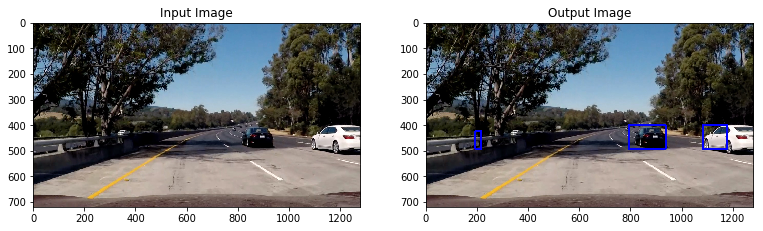

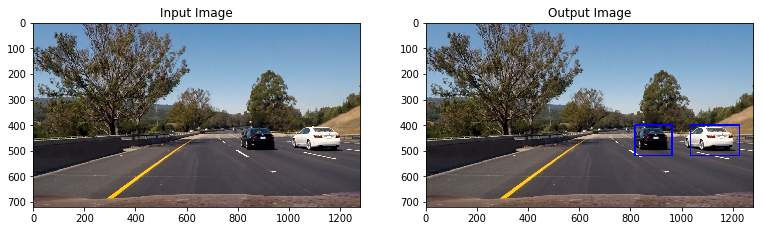

In [551]:
# Test the image processing function
# 1st
final_test_image5 = mpimg.imread('test_images/test5.jpg')
processed_image5 = process_image(final_test_image5)

ttl1 = "Input Image"
ttl2 = "Output Image"
show_two_imgs(final_test_image5,processed_image5,ttl1,ttl2,(10,4))

# 2nd
final_test_image6 = mpimg.imread('test_images/test6.jpg')
processed_image6 = process_image(final_test_image6)

ttl1 = "Input Image"
ttl2 = "Output Image"
show_two_imgs(final_test_image6,processed_image6,ttl1,ttl2,(10,4))

In [552]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'test_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
##clip = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
write_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video test_out.mp4
[MoviePy] Writing video test_out.mp4


 97%|█████████▋| 38/39 [00:10<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_out.mp4 

CPU times: user 10.2 s, sys: 736 ms, total: 10.9 s
Wall time: 12.1 s


In [553]:
write_output = 'project_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
##clip = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
write_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_out.mp4
[MoviePy] Writing video project_out.mp4


100%|█████████▉| 1260/1261 [05:52<00:00,  3.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_out.mp4 

CPU times: user 5min 30s, sys: 20.9 s, total: 5min 51s
Wall time: 5min 53s
